* DataFrame은 Row 타입의 레코드(테이블의 로우 같은)와 각 레코드에 수행할 연산 표현식을 나타내는 여러 컬럼(스프레드시트의 컬럼 같은)으로 구성 
* 스키마는 각 컬럼명과 데이터 타입을 정의 
* DataFrame의 파티셔닝은 DataFrame이나 Dataset이 클러스터에서 물리적으로 배치되는 형태를 정의 
* 파티셔닝 스키마는 파티션을 배치하는 방법을 정의합니다. 

In [2]:
df = spark.read.format("json").load("/data/flight-data/json/2015-summary.json")

In [3]:
df.printSchema()

root
 |-- DEST_COUNTRY_NAME: string (nullable = true)
 |-- ORIGIN_COUNTRY_NAME: string (nullable = true)
 |-- count: long (nullable = true)



# 스키마
* 스키마는 DataFrame의 컬럼명과 데이터 타입을 정의합니다. 데이터소스에서 스키마를 얻거나 직접 정의할 수 있습니다. 
* 운영 환경에서 추출(Extract), 변환(Transform), 적재(Load)를 수행하는 ETL 작업에 스파크를 사용한다면 직접 스키마를 정의해야 합니다. 
* ETL 작업 중에 데이터 타입을 알기 힘든 CSV 파일이나 JSON 등의 데이터소스를 사용하는 경우 스키마 추론 과정에서 읽어 들인 샘플 데이터의 타입에 따라 스키마를 결정해버릴수 있습니다. 

In [4]:
spark.read.format("json").load("/data/flight-data/json/2015-summary.json").schema

StructType(List(StructField(DEST_COUNTRY_NAME,StringType,true),StructField(ORIGIN_COUNTRY_NAME,StringType,true),StructField(count,LongType,true)))

* 스키마는 여러 개의 StructField 타입 필드로 구성된 StructType 객체입니다. 
* StructField는 이름, 데이터 타입, 컬럼이 값이 없거나 null일 수 있는지 지정하는 불리언값을 가집니다. 
* 스파크는 자체 데이터 타입 정보를 사용하므로 프로그래밍 언어의 데이터 타입을 스파크의 데이터 타입으로 설정할 수 없음 

In [5]:
from pyspark.sql.types import StructField, StructType, StringType, LongType
myManualSchema = StructType([
  StructField("DEST_COUNTRY_NAME", StringType(), True),
  StructField("ORIGIN_COUNTRY_NAME", StringType(), True),
  StructField("count", LongType(), False, metadata={"hello":"world"})
])

In [6]:
df = spark.read.format("json").schema(myManualSchema)\
  .load("/data/flight-data/json/2015-summary.json")

In [7]:
df.schema

StructType(List(StructField(DEST_COUNTRY_NAME,StringType,true),StructField(ORIGIN_COUNTRY_NAME,StringType,true),StructField(count,LongType,true)))

# 컬럼과 표현식 
## 컬럼
* 컬럼은 정수형이나 문자열 같은 단순 데이터 타입, 배열이나 맵 같은 복합 데이터 타입 그리고 null 값을 표현합니다. 
* 컬럼을 생성하고 참조할 수 있는 여러 방법이 있지만, col 함수나 column 함수를 사용하는 것이 간단합니다.

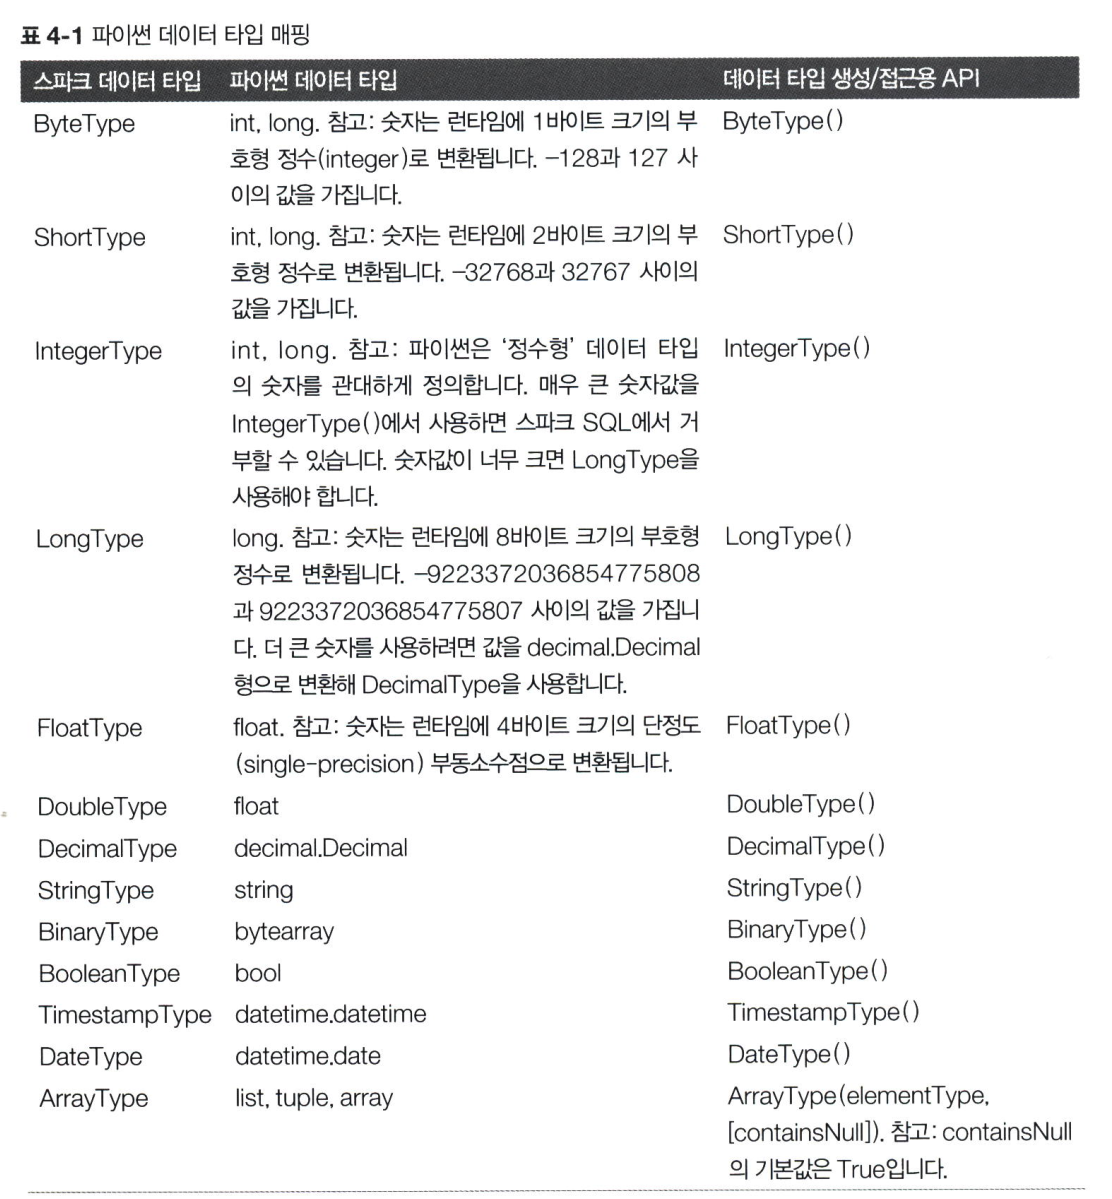

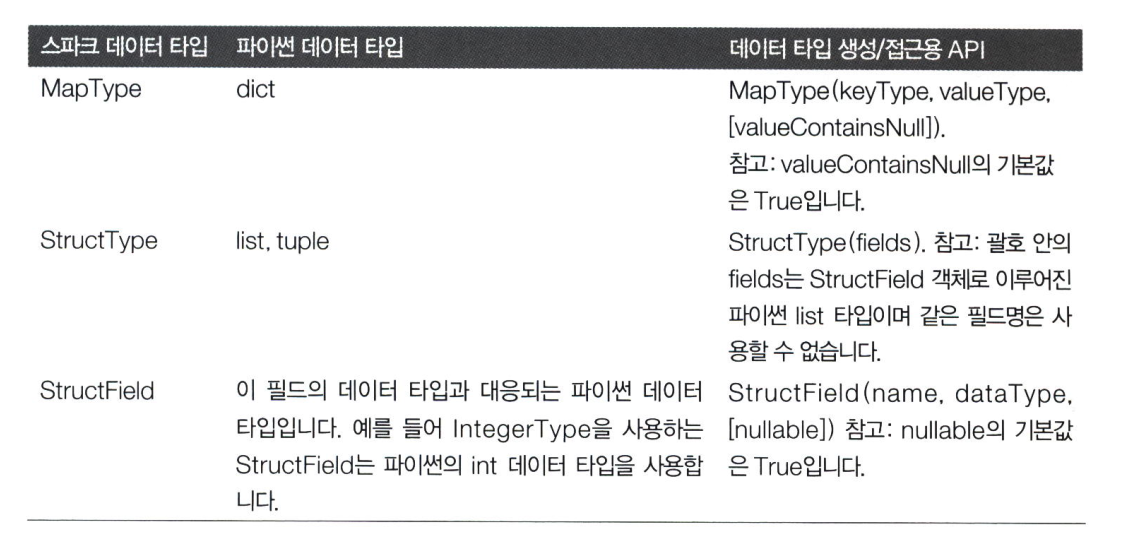

In [8]:
from pyspark.sql.functions import col, column
col("someColumnName")
column("someColumnName")

Column<'someColumnName'>

* 컬럼이 DataFrame에 있는지 없는지는 알 수 없습니다. 
* 컬럼은 컬럼영을 카탈로그에 저장된 정보와 비교하기 전까지 미확인 상태로 남아 있습니다. 

## 표현식
* 표현식은 DataFrame 레코드의 여러 값에 대한 트랜스포메이션 집합을 의미
* 표현식은 expr 함수로 가장 간단히 사용할 수 있습니다. 
* 이 함수를 사용해 DataFrame의 컬럼을 참조할 수 있습니다. 

In [9]:
from pyspark.sql.functions import expr
expr("(((someCol + 5) * 200) - 6) < otherCol")

Column<'((((someCol + 5) * 200) - 6) < otherCol)'>

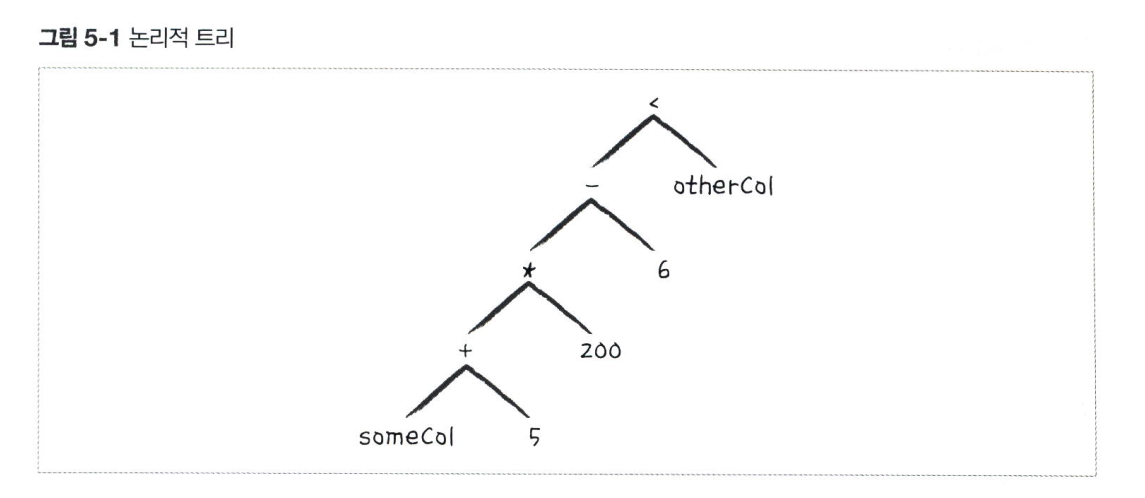

## DataFrame 컬럼에 접근하기 
* columns 속성을 확인하면 컬럼 정보를 확인 할 수 있습니다. 

In [10]:
spark.read.format("json").load("/data/flight-data/json/2015-summary.json").columns

['DEST_COUNTRY_NAME', 'ORIGIN_COUNTRY_NAME', 'count']

# 레코드와 로우
* first 메서드로 로우를 확인할 수 있습니다. 

In [11]:
df.first()

Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Romania', count=15)

## 로우 생성하기 

In [12]:
from pyspark.sql import Row
myRow = Row("Hello", None, 1, False)

In [13]:
type(myRow)

pyspark.sql.types.Row

In [14]:
myRow[0]

'Hello'

In [15]:
myRow[2]

1

# DataFrame의 트랜스포메이션 
* DataFrame을 다루는 방법은 몇 가지 주요 작업으로 나눌 수 있다. 
    * 로우나 컬럼 추가 
    
    * 로우나 컬럼 제거 
    
    * 로우를 컬럼으로 변환하거나, 그 반대로 변환 
    
    * 컬럼값을 기준으로 로우 순서 변경
    

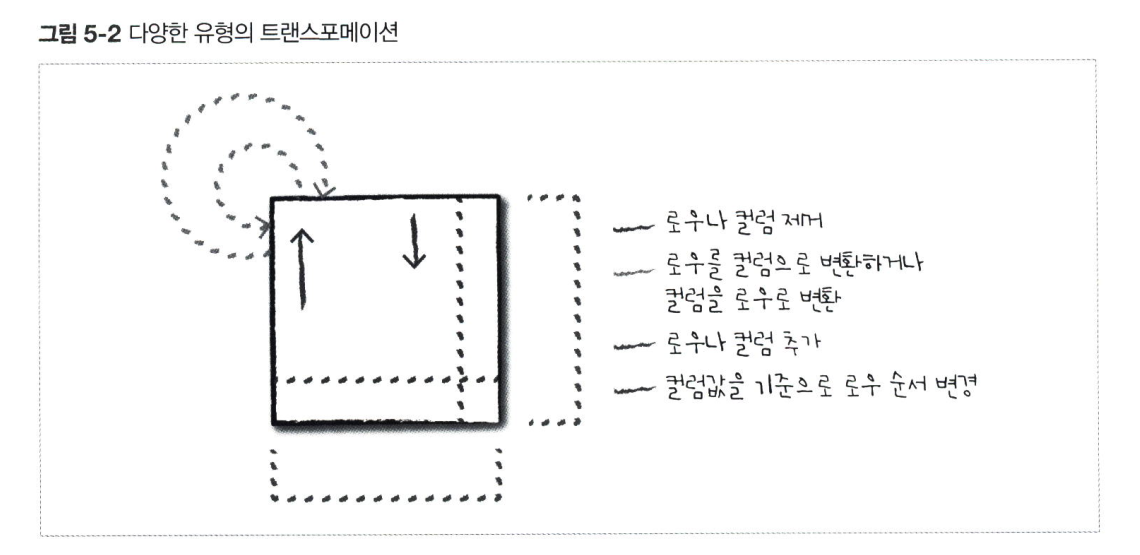

* 이 모든 유형의 작업은 트랜스포메이션으로 변환할 수 있습니다. 

## DataFrame 생성하기 
* 생성한 DataFrame은 SQL 쿼리를 실행하고 SQL의 기본 트랜스포메이션을 확인하기 위해 임시 뷰로 등록 

In [16]:
df = spark.read.format("json").load("/data/flight-data/json/2015-summary.json")
df.createOrReplaceTempView("dfTable")

In [17]:
from pyspark.sql import Row
from pyspark.sql.types import StructField, StructType, StringType, LongType
myManualSchema = StructType([
  StructField("some", StringType(), True),
  StructField("col", StringType(), True),
  StructField("names", LongType(), False)
])
myRow = Row("Hello", None, 1)
myDf = spark.createDataFrame([myRow], myManualSchema)
myDf.show()

+-----+----+-----+
| some| col|names|
+-----+----+-----+
|Hello|null|    1|
+-----+----+-----+



#### 유용하게 사용할 수 있는 메서드 
* 컬럼이나 표현식을 사용하는 select 메서드 
* 문자열 표현식을 사용하는 selectExpr 메서드 
* 메서드로 사용할 수 없는 org.apache.spark,sql, functions 패키지에 포함된 다양함 함수 

## select와 selectExpr
* 테이블에 SQL을 실행하는 것처럼 DataFrame에서도 SQL를 사용할 수 있다 

In [18]:
df.select("DEST_COUNTRY_NAME").show(2)

+-----------------+
|DEST_COUNTRY_NAME|
+-----------------+
|    United States|
|    United States|
+-----------------+
only showing top 2 rows



In [19]:
df.select(col("DEST_COUNTRY_NAME").alias("dest"), expr("ORIGIN_COUNTRY_NAME as origin")).show(2)

+-------------+-------+
|         dest| origin|
+-------------+-------+
|United States|Romania|
|United States|Croatia|
+-------------+-------+
only showing top 2 rows



In [20]:
from pyspark.sql.functions import expr, col, column
df.select(
    expr("DEST_COUNTRY_NAME"),
    col("DEST_COUNTRY_NAME"),
    column("DEST_COUNTRY_NAME"))\
  .show(2)

+-----------------+-----------------+-----------------+
|DEST_COUNTRY_NAME|DEST_COUNTRY_NAME|DEST_COUNTRY_NAME|
+-----------------+-----------------+-----------------+
|    United States|    United States|    United States|
|    United States|    United States|    United States|
+-----------------+-----------------+-----------------+
only showing top 2 rows



In [21]:
df.select(col('count').alias("cnt"),expr("DEST_COUNTRY_NAME AS destination")).show(2)

+---+-------------+
|cnt|  destination|
+---+-------------+
| 15|United States|
|  1|United States|
+---+-------------+
only showing top 2 rows



* select 메서드에 expr 함수를 사용하는 패턴은 쉽게 볼 수 있음 

In [22]:
df.select(expr("DEST_COUNTRY_NAME as destination").alias("DEST_COUNTRY_NAME"))\
  .show(2)

+-----------------+
|DEST_COUNTRY_NAME|
+-----------------+
|    United States|
|    United States|
+-----------------+
only showing top 2 rows



* select 메서드에 expr 함수를 사용하는 패턴은 쉽게 볼 수 있음 

* selectExpr 메서드는 스파크의 진정한 능력을 보여줍니다. selectExpr 메서드는 새로운 DataFrame을 생성하는 복잡한 표현식을 간단하게 만드는 도구

In [23]:
df.selectExpr("DEST_COUNTRY_NAME as newColumnName", "DEST_COUNTRY_NAME").show(2)

+-------------+-----------------+
|newColumnName|DEST_COUNTRY_NAME|
+-------------+-----------------+
|United States|    United States|
|United States|    United States|
+-------------+-----------------+
only showing top 2 rows



In [24]:
a = 100
eval("{} + 10".format(a))

110

* DataFrame에 출발지와 도착지가 같은지 나타내는 새로운 withinCountry 컬럼을 추가하는 예제 

In [25]:
df.select('*', expr("(DEST_COUNTRY_NAME = ORIGIN_COUNTRY_NAME) as withinCountry")).show()

+--------------------+-------------------+-----+-------------+
|   DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|withinCountry|
+--------------------+-------------------+-----+-------------+
|       United States|            Romania|   15|        false|
|       United States|            Croatia|    1|        false|
|       United States|            Ireland|  344|        false|
|               Egypt|      United States|   15|        false|
|       United States|              India|   62|        false|
|       United States|          Singapore|    1|        false|
|       United States|            Grenada|   62|        false|
|          Costa Rica|      United States|  588|        false|
|             Senegal|      United States|   40|        false|
|             Moldova|      United States|    1|        false|
|       United States|       Sint Maarten|  325|        false|
|       United States|   Marshall Islands|   39|        false|
|              Guyana|      United States|   64|       

In [26]:
df.selectExpr(
  "*", # all original columns
  "(DEST_COUNTRY_NAME = ORIGIN_COUNTRY_NAME) as withinCountry")\
  .show(2)

+-----------------+-------------------+-----+-------------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|withinCountry|
+-----------------+-------------------+-----+-------------+
|    United States|            Romania|   15|        false|
|    United States|            Croatia|    1|        false|
+-----------------+-------------------+-----+-------------+
only showing top 2 rows



In [27]:
df.selectExpr("avg(count) as average", "count(distinct(DEST_COUNTRY_NAME))").show(2)

+-----------+---------------------------------+
|    average|count(DISTINCT DEST_COUNTRY_NAME)|
+-----------+---------------------------------+
|1770.765625|                              132|
+-----------+---------------------------------+



## 스파크 데이터 타입으로 변환하기 
* 때로는 새로운 컬럼이 아닌 명시적인 값을 스파크에 전달해야 합니다. 
* 명시적인 값은 상숫값일 수 있고, 추후 비교에 사용할 무언가가 될 수 도 있음 
* 이때 리터럴 상수를 사용 

In [28]:
from pyspark.sql.functions import lit
df.select(expr("*"), lit(1).alias("One")).show(2)

+-----------------+-------------------+-----+---+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|One|
+-----------------+-------------------+-----+---+
|    United States|            Romania|   15|  1|
|    United States|            Croatia|    1|  1|
+-----------------+-------------------+-----+---+
only showing top 2 rows



## 컬럼 추가하기 
* withColumn 메서드를 사용하여 추가할 수 있다. 
* wichColumn 메서드는 두 개의 인수를 사용. 하나는 컬러명, 다른 하나는 값을 생성할 표현식 

In [29]:
df.withColumn("numberOne", lit(1)).show(2)

+-----------------+-------------------+-----+---------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|numberOne|
+-----------------+-------------------+-----+---------+
|    United States|            Romania|   15|        1|
|    United States|            Croatia|    1|        1|
+-----------------+-------------------+-----+---------+
only showing top 2 rows



In [30]:
df.withColumn("withinCountry", expr("ORIGIN_COUNTRY_NAME == DEST_COUNTRY_NAME"))\
  .show(2)

+-----------------+-------------------+-----+-------------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|withinCountry|
+-----------------+-------------------+-----+-------------+
|    United States|            Romania|   15|        false|
|    United States|            Croatia|    1|        false|
+-----------------+-------------------+-----+-------------+
only showing top 2 rows



## 컬럼명 변경하기 
* withcolumnsRenamed 메서드를 사용하여 컬럼명을 변경할 수 있다. 


In [31]:
df.withColumnRenamed("DEST_COUNTRY_NAME", "dest").columns

['dest', 'ORIGIN_COUNTRY_NAME', 'count']

In [32]:
df

DataFrame[DEST_COUNTRY_NAME: string, ORIGIN_COUNTRY_NAME: string, count: bigint]

## 예약 문자와 키워드
* 하이픈(-) 같은 예약 문자는 컬럼명에 사용할 수없습니다. 
* 예약 문자를 컬럼명에 사용하려면 백틱(`)문자를 이스케이핑해야 합니다. 

In [33]:
dfWithLongColName = df.withColumn(
    "This Long Column-Name",
    expr("ORIGIN_COUNTRY_NAME"))

In [34]:
dfWithLongColName.show(5)

+-----------------+-------------------+-----+---------------------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|This Long Column-Name|
+-----------------+-------------------+-----+---------------------+
|    United States|            Romania|   15|              Romania|
|    United States|            Croatia|    1|              Croatia|
|    United States|            Ireland|  344|              Ireland|
|            Egypt|      United States|   15|        United States|
|    United States|              India|   62|                India|
+-----------------+-------------------+-----+---------------------+
only showing top 5 rows



* 표현식으로 컬럼을 참조할 때 백틱(`)을 사용하여 조회

In [35]:
eval("10 - 5")

5

In [36]:
dfWithLongColName.selectExpr(
    "`This Long Column-Name`",
    "`This Long Column-Name` as `new col`")\
  .show(2)


+---------------------+-------+
|This Long Column-Name|new col|
+---------------------+-------+
|              Romania|Romania|
|              Croatia|Croatia|
+---------------------+-------+
only showing top 2 rows



## 컬럼 제거 
* drop 메서드를 사용하여 제거할 수 있음

In [37]:
df.drop("DEST_COUNTRY_NAME").columns

['ORIGIN_COUNTRY_NAME', 'count']

In [38]:
df.columns

['DEST_COUNTRY_NAME', 'ORIGIN_COUNTRY_NAME', 'count']

In [39]:
df.drop('DEST_COUNTRY_NAME', 'ORIGIN_COUNTRY_NAME')

DataFrame[count: bigint]

## 컬럼의 데이터 타입 변경하기 
* 작업 진행시 데이터 타입을 다른 데이터 타입으로 형변환할 필요가 있습니다. 
* 다수의 StringType컬럼을 정수형으로 변환해야 하는 경우가 그 예 
* cast 메서드로 데이터 타입을 변환할 수 있습니다. 

In [40]:
df.withColumn("count2", col('count').cast('string'))

DataFrame[DEST_COUNTRY_NAME: string, ORIGIN_COUNTRY_NAME: string, count: bigint, count2: string]

## 필터링 

In [41]:
df.where(expr("count") < 2).where(col("ORIGIN_COUNTRY_NAME") != "Croatia")\
  .show(2)

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|          Singapore|    1|
|          Moldova|      United States|    1|
+-----------------+-------------------+-----+
only showing top 2 rows



* where 메서드를 여러 번 사용해 필터를 적용

## 고유한 로우 얻기 

In [42]:
df.select("ORIGIN_COUNTRY_NAME", "DEST_COUNTRY_NAME").distinct().count()

256

In [43]:
df.select("ORIGIN_COUNTRY_NAME", "DEST_COUNTRY_NAME").distinct().show()

+-------------------+--------------------+
|ORIGIN_COUNTRY_NAME|   DEST_COUNTRY_NAME|
+-------------------+--------------------+
|            Romania|       United States|
|            Croatia|       United States|
|            Ireland|       United States|
|      United States|               Egypt|
|              India|       United States|
|          Singapore|       United States|
|            Grenada|       United States|
|      United States|          Costa Rica|
|      United States|             Senegal|
|      United States|             Moldova|
|       Sint Maarten|       United States|
|   Marshall Islands|       United States|
|      United States|              Guyana|
|      United States|               Malta|
|      United States|            Anguilla|
|      United States|             Bolivia|
|           Paraguay|       United States|
|      United States|             Algeria|
|      United States|Turks and Caicos ...|
|          Gibraltar|       United States|
+----------

## 무작위 샘플 만들기

In [44]:
df.count()

256

In [45]:
seed = 5
withReplacement = False
fraction = 0.5
df.sample(withReplacement, fraction, seed).count()

138

## 임의 분할하기 
* 원본 DataFrame을 임의 크기로 '분할'할 때 유용하게 사용됩니다 
* 이 기능은 머신러닝 알고리즘에서 사용할 학습셋, 검증셋 그리고 테스트셋을 만들 대 주로 사용합니다. 

In [46]:
dataFrames = df.randomSplit([0.25, 0.75], seed)
dataFrames[0].count() > dataFrames[1].count() # False 

False

In [47]:
dataFrames[0].count()

71

In [48]:
dataFrames[1].count()

185

### 로우 합치기와 추가하기
* DataFrame은 불변성을 가집니다. 그러므로 DataFrame에 레코드를 추가하는 작업은 DataFrame을 변경하는 작업이기 때문에 불가능 
* DataFrame에 레코드를 추가하려면 원본 DataFrame을 새로운 DataFrame과 통합(union)해야 합니다. 
* 통합은 두 개의 DataFrame을 단순히 결합하는 행위
* 반드시 동일한 스키마와 컬럼수를 가져야 합니다. 

In [49]:
from pyspark.sql import Row
schema = df.schema
newRows = [
  Row("New Country", "Other Country", 5),
  Row("New Country 2", "Other Country 3", 1)
]
parallelizedRows = spark.sparkContext.parallelize(newRows)
newDF = spark.createDataFrame(parallelizedRows, schema)


In [50]:
df.count()

256

In [51]:
df.union(newDF).count()

258

In [52]:
df.union(newDF)\
  .where("count = 1")\
  .where(col("ORIGIN_COUNTRY_NAME") != "United States")\
  .show()

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Croatia|    1|
|    United States|          Singapore|    1|
|    United States|          Gibraltar|    1|
|    United States|             Cyprus|    1|
|    United States|            Estonia|    1|
|    United States|          Lithuania|    1|
|    United States|           Bulgaria|    1|
|    United States|            Georgia|    1|
|    United States|            Bahrain|    1|
|    United States|   Papua New Guinea|    1|
|    United States|         Montenegro|    1|
|    United States|            Namibia|    1|
|    New Country 2|    Other Country 3|    1|
+-----------------+-------------------+-----+



In [53]:
df.union(newDF).count()

258

### row 정렬 

In [54]:
df.sort("count", "DEST_COUNTRY_NAME").show(5)
df.orderBy("count", "DEST_COUNTRY_NAME").show(5)
df.orderBy(column("count").desc(), col("DEST_COUNTRY_NAME")).show(5)

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|     Burkina Faso|      United States|    1|
|    Cote d'Ivoire|      United States|    1|
|           Cyprus|      United States|    1|
|         Djibouti|      United States|    1|
|        Indonesia|      United States|    1|
+-----------------+-------------------+-----+
only showing top 5 rows

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|     Burkina Faso|      United States|    1|
|    Cote d'Ivoire|      United States|    1|
|           Cyprus|      United States|    1|
|         Djibouti|      United States|    1|
|        Indonesia|      United States|    1|
+-----------------+-------------------+-----+
only showing top 5 rows

+-----------------+-------------------+------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME| count|
+-----------------+---------